In [1]:
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 26.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import gym
from gym import spaces
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import PPO
from tqdm import tqdm

In [3]:
!pip install 'shimmy>=0.2.1'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.3/954.3 kB 26.1 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 0.29.1
    Uninstalling gymnasium-0.29.1:
      Successfully uninstalled gymnasium-0.29.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
stable-baselines3 2.3.2 requires gymnasium<0.30,>=0.28.1, but you have gymnasium 1.0.0a2 which is incompatible.


In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Path to the data file (Update this with your data path)
file_path = '/content/drive/MyDrive/clean_data.csv'

In [ ]:
# Simulated external data
def augment_data_with_more_external(data):
    np.random.seed(42)
    temperature = np.random.uniform(15, 35, size=(len(data), 1))
    gdp = np.random.uniform(50000, 100000, size=(len(data), 1))
    interest_rate = np.random.uniform(0.5, 5, size=(len(data), 1))
    inflation = np.random.uniform(1, 10, size=(len(data), 1))
    return np.hstack([temperature, gdp, interest_rate, inflation])

# Apply the new augmentation function
external_data_expanded = augment_data_with_more_external(data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Scaling the original and external data separately
scaler_data = MinMaxScaler()
scaler_external = MinMaxScaler()

scaled_data = scaler_data.fit_transform(data[['price', 'revenue', 'sales']])
scaled_external_expanded = scaler_external.fit_transform(external_data_expanded)

In [ ]:
# Updating training and testing splits
X_train, X_test, ext_train_expanded, ext_test_expanded = train_test_split(scaled_data, scaled_external_expanded, test_size=0.2, random_state=42)

In [ ]:
# Variational Autoencoder (VAE) for Synthetic Data Generation
latent_dim = 2
input_dim = X_train.shape[1]

In [ ]:
def build_encoder(input_dim, latent_dim):
    inputs = layers.Input(shape=(input_dim,))
    h = layers.Dense(64, activation='relu')(inputs)
    z_mean = layers.Dense(latent_dim)(h)
    z_log_var = layers.Dense(latent_dim)(h)
    return models.Model(inputs, [z_mean, z_log_var])

def build_decoder(latent_dim, output_dim):
    latent_inputs = layers.Input(shape=(latent_dim,))
    h = layers.Dense(64, activation='relu')(latent_inputs)
    outputs = layers.Dense(output_dim, activation='sigmoid')(h)
    return models.Model(latent_inputs, outputs)

def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

encoder = build_encoder(input_dim, latent_dim)
decoder = build_decoder(latent_dim, input_dim)

z_mean, z_log_var = encoder.output
z = layers.Lambda(sampling)([z_mean, z_log_var])

vae_output = decoder(z)
vae = models.Model(encoder.input, vae_output)

In [ ]:
# Custom Loss Layer with beta weighting for KL divergence
class VAELossLayer(tf.keras.layers.Layer):
    def __init__(self, beta=1.0, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)
        self.beta = beta
        self.mse_loss_fn = tf.keras.losses.MeanSquaredError()

    def call(self, inputs):
        x, x_decoded, z_mean, z_log_var = inputs

        # Reconstruction loss (MSE)
        reconstruction_loss = self.mse_loss_fn(x, x_decoded)
        reconstruction_loss *= input_dim

        # KL divergence loss
        kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
        kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
        kl_loss *= -0.5 * self.beta

        # Add the combined loss
        total_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)
        self.add_loss(total_loss)

        return x_decoded

# Wrap the decoder with the custom loss layer
vae_output = VAELossLayer(beta=0.5)([encoder.input, vae_output, z_mean, z_log_var])

In [ ]:
# Compile the VAE model
vae = models.Model(encoder.input, vae_output)
vae.compile(optimizer='adam')

In [ ]:
# Train the VAE
history = vae.fit(X_train, epochs=50, batch_size=32, validation_data=(X_test, None))

Epoch 1/50
2147/2147 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 0.0822 - val_loss: 0.0072
Epoch 2/50
2147/2147 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0067 - val_loss: 0.0071
Epoch 3/50
2147/2147 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0065 - val_loss: 0.0070
Epoch 4/50
2147/2147 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0065 - val_loss: 0.0070
Epoch 5/50
2147/2147 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0068 - val_loss: 0.0070
Epoch 6/50
2147/2147 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0065 - val_loss: 0.0070
Epoch 7/50
2147/2147 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0064 - val_loss: 0.0070
Epoch 8/50
2147/2147 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0064 - val_loss: 0.0070
Epoch 9/50
2147/2147 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0063 - val_loss: 0.0070
Epoch 10/50
2147/2147 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0063 - val_loss: 0.0070
Epoch 11/50
2147/2147 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0065 - val_loss: 0.0070
Epoch 12/50
2147/2147 ━━━━━

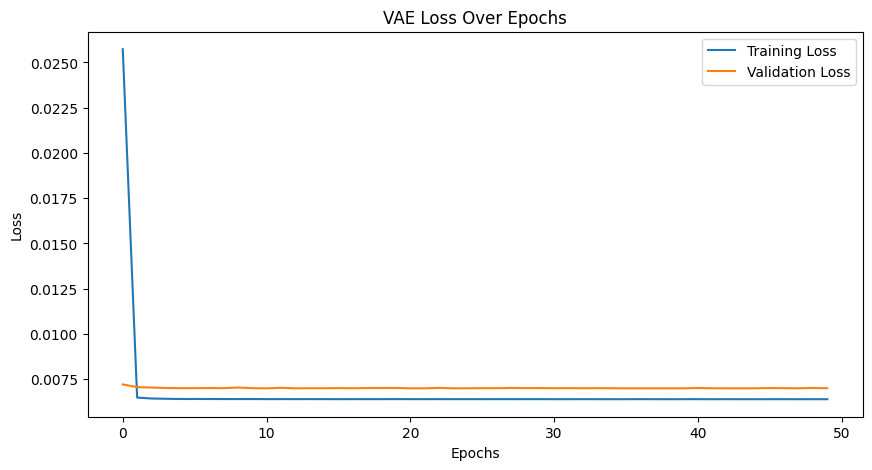

In [ ]:
# Plot VAE loss
def plot_vae_loss(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('VAE Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_vae_loss(history)

In [ ]:
# Generate synthetic data using the trained VAE
synthetic_data = vae.predict(X_test)

537/537 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
# Conditional GAN (cGAN) for Scenario Forecasting
def build_generator(latent_dim, condition_dim, output_dim):
    inputs = layers.Input(shape=(latent_dim + condition_dim,))
    h = layers.Dense(64, activation='relu')(inputs)
    output = layers.Dense(output_dim, activation='sigmoid')(h)
    return models.Model(inputs, output)

def build_discriminator(input_dim, condition_dim):
    inputs = layers.Input(shape=(input_dim + condition_dim,))
    h = layers.Dense(64, activation='relu')(inputs)
    output = layers.Dense(1, activation='sigmoid')(h)
    return models.Model(inputs, output)

In [ ]:
# Rebuild the generator and discriminator models
generator = build_generator(latent_dim, ext_train_expanded.shape[1], input_dim)
discriminator = build_discriminator(input_dim, ext_train_expanded.shape[1])
discriminator.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
# Ensure that the discriminator's trainable flag is properly handled
discriminator.trainable = False

# Define the cGAN model
z = layers.Input(shape=(latent_dim,))
condition = layers.Input(shape=(ext_train_expanded.shape[1],))

# Concatenate z and condition to form a single input tensor
gen_input = layers.concatenate([z, condition])

# Generate fake data from the generator
generated_output = generator(gen_input)

# Concatenate generated output with the condition and pass it to the discriminator
discriminator_input = layers.concatenate([generated_output, condition])

# Get the validity output from the discriminator
validity = discriminator(discriminator_input)

In [ ]:
# Define the complete cGAN model
cgan = models.Model([z, condition], validity)
cgan.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
# Training the cGAN
epochs = 2000
batch_size = 32

valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

generator_losses = []
discriminator_losses = []

In [ ]:
for epoch in range(epochs):
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_data = X_train[idx]
    conditions = np.random.normal(size=(batch_size, ext_train_expanded.shape[1]))

    # Generate latent space samples
    z = np.random.normal(size=(batch_size, latent_dim))

    # Concatenate z and conditions before passing to the generator
    gen_input = np.concatenate([z, conditions], axis=1)

    # Generate fake data
    fake_data = generator.predict(gen_input)

    # Train the discriminator (real data and fake data)
    discriminator.trainable = True
    d_loss_real = discriminator.train_on_batch(np.hstack([real_data, conditions]), valid)
    d_loss_fake = discriminator.train_on_batch(np.hstack([fake_data, conditions]), fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    discriminator_losses.append(d_loss)
    discriminator.trainable = False

    # Train the generator (we want the generator to fool the discriminator)
    g_loss = cgan.train_on_batch([z, conditions], valid)
    generator_losses.append(g_loss)

    if epoch % 1000 == 0:
        print(f"{epoch}/{epochs}, D Loss: {d_loss}, G Loss: {g_loss}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
0/2000, D Loss: 0.8428393602371216, G Loss: [array(0.6964715, dtype=float32), array(0.6964715, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

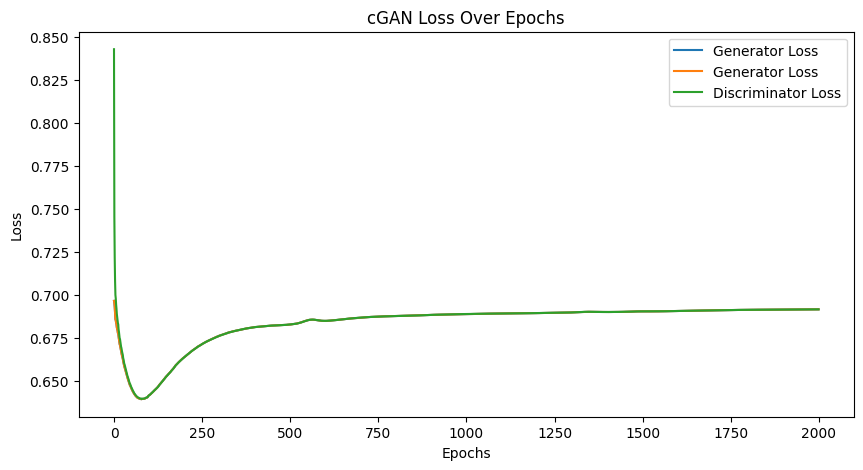

In [ ]:
# Plot cGAN loss
def plot_cgan_loss(generator_losses, discriminator_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(generator_losses, label='Generator Loss')
    plt.plot(discriminator_losses, label='Discriminator Loss')
    plt.title('cGAN Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_cgan_loss(generator_losses, discriminator_losses)

In [ ]:
# Define future conditions with appropriate values
future_conditions = np.random.normal(size=(32, ext_train_expanded.shape[1]))

# Concatenate z and future_conditions before passing to the generator
gen_input = np.concatenate([z, future_conditions], axis=1)

# Generate future prediction
future_prediction = generator.predict(gen_input)

# Reverse scaling for interpretation
future_prediction_rescaled = scaler_data.inverse_transform(future_prediction)
print("Generated Future Scenario:", future_prediction_rescaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Generated Future Scenario: [[   5.9598413   53.148697   264.85773  ]
 [   8.8031845   63.112225   983.417    ]
 [  15.645138   238.30745   1205.0208   ]
 [  11.513711   211.56425   1971.9045   ]
 [   8.638835   113.796005  1185.5787   ]
 [  13.1771     165.51431    725.1654   ]
 [  11.013664    57.32132    261.6738   ]
 [   6.618857    66.40303    439.82812  ]
 [   9.829555   152.50793    971.1314   ]
 [  11.872312    70.33349    249.08559  ]
 [   5.946765    61.40415    462.17267  ]
 [  11.915145   128.0802     697.46686  ]
 [   8.365759    49.16121    384.52054  ]
 [   5.5598917   17.173246   139.26778  ]
 [  11.195392   185.85893    971.8011   ]
 [  10.606915    91.22564    818.8806   ]
 [   7.4402933  138.88982   1466.5515   ]
 [   7.1925297   72.45254    451.37054  ]
 [   6.5557914   63.99628    402.55643  ]
 [  15.488374   294.19388   1756.4922   ]
 [  14.12144    330.5414    1732.183    ]
 [   7.675666    31.777355   224.04106  ]
 [   5.5593

In [ ]:
# Multi-Agent Reinforcement Learning (RL)
class MultiAgentElectricityEnv(gym.Env):
    def __init__(self, data, external_data, num_agents=3):
        super(MultiAgentElectricityEnv, self).__init__()
        self.num_agents = num_agents
        self.data = data
        self.external_data = external_data
        self.current_step = 0
        self.observation_space = spaces.Box(low=0, high=1, shape=(data.shape[1] + external_data.shape[1],))
        self.action_space = spaces.Discrete(3)

    def step(self, actions):
        rewards = []
        done = False
        obs_list = []

        for agent_id in range(self.num_agents):
            current_data = self.data[self.current_step]
            current_external = self.external_data[self.current_step]
            price_change = 0
            if actions[agent_id] == 0:
                price_change = -0.1
            elif actions[agent_id] == 2:
                price_change = 0.1

            new_price = current_data[0] + price_change
            new_revenue = new_price * current_data[2]
            reward = new_revenue
            rewards.append(reward)

            obs = np.hstack([self.data[self.current_step], self.external_data[self.current_step]])
            obs_list.append(obs)

        self.current_step += 1
        if self.current_step >= len(self.data) - 1:
            done = True

        return obs_list, rewards, done, {}

    def reset(self):
        self.current_step = 0
        obs_list = np.array([np.hstack([self.data[self.current_step], self.external_data[self.current_step]])
                             for _ in range(self.num_agents)])
        return obs_list

    def render(self):
        pass

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Multi-Agent Reinforcement Learning (RL) Setup
env = MultiAgentElectricityEnv(X_train, ext_train_expanded, num_agents=3)

# Each agent will have its own policy
agents = [PPO("MlpPolicy", env, verbose=1) for _ in range(env.num_agents)]

# Track rewards for each agent
episode_rewards = [[] for _ in range(env.num_agents)]

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [ ]:
# Training loop for multi-agent reinforcement learning
epochs = 50  # Define the number of training episodes

# Initialize the progress bar
for epoch in tqdm(range(epochs), desc="Training Progress"):
    observations = env.reset()
    done = False

    # Reset episode rewards
    rewards_episode = [0 for _ in range(env.num_agents)]

    while not done:
        # Agents take actions based on their current observation
        actions = [agent.predict(obs)[0] for agent, obs in zip(agents, observations)]

        # Environment steps with the agents' actions
        observations, rewards, done, _ = env.step(actions)

        # Accumulate rewards
        for i in range(env.num_agents):
            rewards_episode[i] += rewards[i]

    # Track rewards for each agent per episode
    for i in range(env.num_agents):
        episode_rewards[i].append(rewards_episode[i])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Training Progress: 100%|██████████| 50/50 [2:07:28<00:00, 152.97s/it]


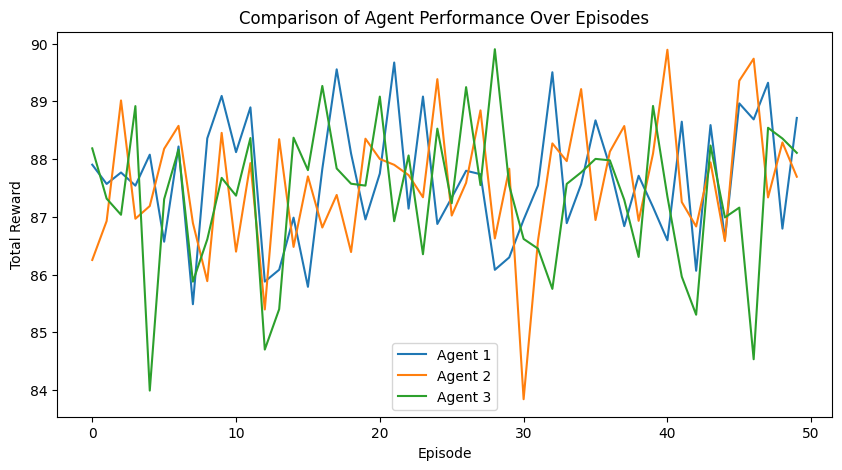

In [ ]:
# Plot Agent Rewards Over Time
def plot_multi_agent_performance(agent_rewards):
    plt.figure(figsize=(10, 5))
    for agent_id, rewards in enumerate(agent_rewards):
        plt.plot(rewards, label=f'Agent {agent_id + 1}')
    plt.title('Comparison of Agent Performance Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.show()

plot_multi_agent_performance(episode_rewards)

In [ ]:
# Scenario Simulation and Testing with Trained Agents using Expanded Features
env_test = MultiAgentElectricityEnv(future_prediction_rescaled, ext_test_expanded, num_agents=3)
obs = env_test.reset()

test_episode_rewards = [0 for _ in range(env_test.num_agents)]

for step in range(200):
    # Each agent takes an action based on their learned policy
    actions = [agent.predict(obs)[0] for agent, obs in zip(agents, obs)]

    # Step through the environment with the actions
    obs, rewards, done, _ = env_test.step(actions)

    # Accumulate rewards
    for i in range(env_test.num_agents):
        test_episode_rewards[i] += rewards[i]

    if done:
        break

print(f"Test Episode Rewards with Expanded Features: {test_episode_rewards}")

Test Episode Rewards with Expanded Features: [233365.2641808201, 232394.31062933698, 231511.2762524296]


In [ ]:
# Plot Action Distributions for Agents
def plot_action_distribution(actions):
    plt.figure(figsize=(7, 5))
    plt.hist(actions, bins=np.arange(-0.5, 3, 1), rwidth=0.8)
    plt.xticks([0, 1, 2], ['Decrease', 'Keep', 'Increase'])
    plt.title('Distribution of Agent Actions')
    plt.xlabel('Action')
    plt.ylabel('Frequency')
    plt.show()

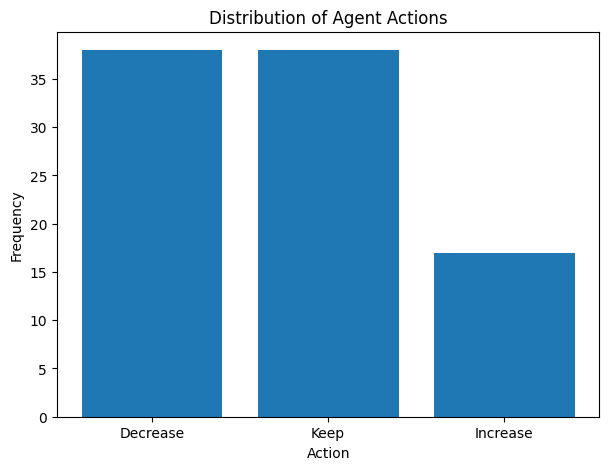

In [ ]:
# Assuming actions are tracked during RL testing
actions = []
obs = env_test.reset()

for step in range(200):
    step_actions = [agent.predict(obs)[0] for agent, obs in zip(agents, obs)]
    actions.extend(step_actions)
    obs, _, done, _ = env_test.step(step_actions)
    if done:
        break

plot_action_distribution(actions)

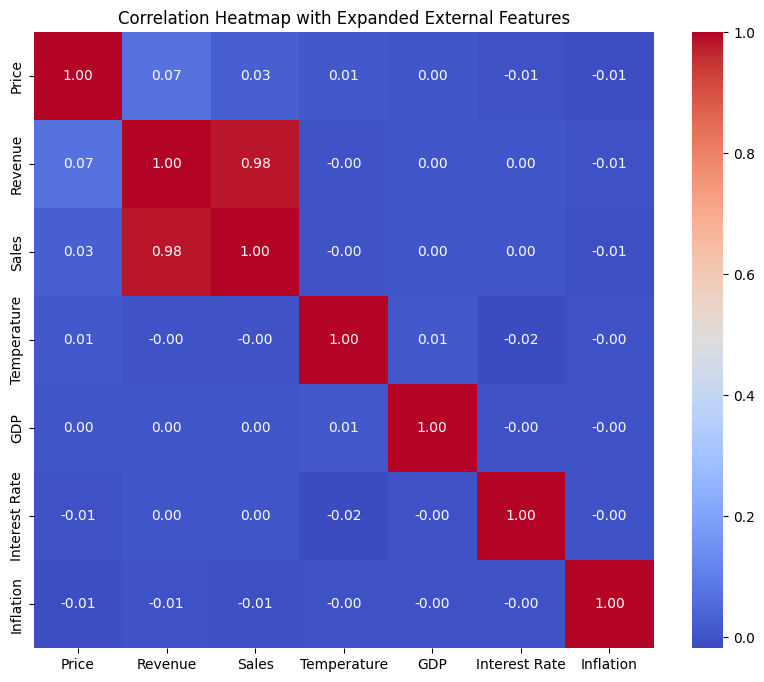

In [ ]:
# Correlation Heatmap for Expanded External Data and Scenario Data
def plot_correlation_heatmap_expanded(data, external_data):
    combined_data = np.hstack([data, external_data])
    combined_df = pd.DataFrame(combined_data, columns=['Price', 'Revenue', 'Sales', 'Temperature', 'GDP', 'Interest Rate', 'Inflation'])

    # Correlation matrix and heatmap
    corr_matrix = combined_df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap with Expanded External Features')
    plt.show()

plot_correlation_heatmap_expanded(X_test, ext_test_expanded)